In [1]:
import torch
import time 
import copy
import os
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

In [23]:
data_dir = r"D:\Fastai\dl2\data\train"
batch_size = 8
validation_split = 0.2
shuffle_dataset = True
random_seed = 21

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
print(len(image_dataset))
dataset_size = len(image_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=batch_size, sampler=valid_sampler)

dataloaders = {'train': train_loader, 'val': validation_loader}
datasets_sizes = {
    'train': len(train_loader) * batch_size,
    'val': len(validation_loader) * batch_size
}
print(datasets_sizes)

1023
{'train': 824, 'val': 208}


In [4]:
model_ft = torch.load(r'glasses/model.pth')

In [24]:
def compute_saliency_map(X, y, model):
    saliency = None
    X_var = torch.autograd.Variable(X, requires_grad=True)
    y_var = torch.autograd.Variable(y, requires_grad=False)
    
    # calculate score outputted by model
    score = model(X_var)
    score = score.gather(1, y_var.view(-1, 1)).squeeze()
    
    score.backward(torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))
    
    saliency = X_var.grad.data
    saliency = saliency.abs()
    saliency, i = torch.max(saliency,dim=1)
    saliency = saliency.squeeze()
    
    return saliency

In [30]:
def show_saliency(trainLoader, model_ft):
    train_iter = iter(trainLoader)
    X, y = train_iter.next()
    saliency = compute_saliency_map(X, y, model_ft)
    class_names = ['glasses', 'no-glasses']
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()
    imshow(torchvision.utils.make_grid(X))

In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


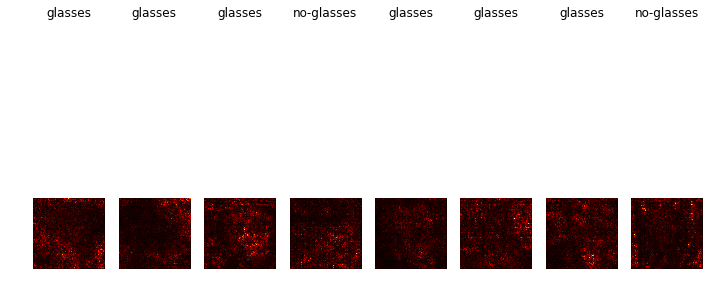

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


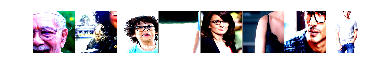

In [35]:
show_saliency(train_loader, model_ft)